In [1]:
# Development cell: it automatically reloads modified code in the various modules
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import numpy as np
import sympy as sp

sp.init_printing()

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

- True population distribution

$$ X_i \sim p_\text{T}(x) = \mathcal{N}(0,1)$$

- Measurements distribution

$$ X_i^{(m)} \sim p_m(x) = p(x^{(m)} | x) = \mathcal{N}(x^{(m)}, \mu=x,\sigma=\sigma_\text{N})$$

- Model

$$ p(x | \vec{w}) = \sum_{i=1}^{N_w} w_i \delta(x - \hat{x}_i)$$

- We would like to understand which are the most probable weights given the data

$$ p(\vec{w} | \{x_i^{(m)}\}) \propto p(\{x_i^{(m)}\} | \vec{w})\; p(\vec{w})$$

- The right thing to do would be to sample $\vec{w}$ according to $p(\vec{w} | \{x_i^{(m)}\})$
- Alternatively

$$\vec{w}_\text{MAP} = \argmax_{\vec{w}} p(\vec{w} | \{x_i^{(m)}\})$$

- Study the distribution

$$ p(x)_\text{MAP} = p(x | \vec{w}_\text{MAP}) = \sum_{i=1}^{N_w} w_{(\text{MAP}), i} \delta(x - \hat{x}_i)$$

- Let's introduce the moments

$$ p(\vec{w}, \vec{m} | \{x_i^{(m)}\}) \propto p(\{x_i^{(m)}\} | \vec{w})\; p(\vec{w} | \vec{m})\;p(\vec{m})$$

- One could use the maximum entropy principle and maximize the entropy of the above expression subject to contraints

$$ \langle \log p(\vec{w}, \vec{m} | \{x_i^{(m)}\})\rangle_p \propto \langle \log p(\{x_i^{(m)}\} | \vec{w}) \rangle_p + \langle \log p(\vec{w} | \vec{m}) \rangle_p + \langle \log p(\vec{m}) \rangle_p + \sum_k \lambda_k \left(\sum_{i=1}^{N_w} w_i \hat{x}_i^k - m_k\right)$$

- For now we use 

$$ p(\{x_i^{(m)}\} | \vec{w}) = \int \text{d} x\, p(\{x_i^{(m)}\}, x | \vec{w}) = \prod_{i=1}^N \int \text{d} x\, p(x_i^{(m)} | x)\; p(x | \vec{w}) = \prod_{i=1}^N \sum_{j=1}^{N_w} w_j p(x_i^{(m)}| \hat{x}_j) = \prod_{i=1}^N \sum_{j=1}^{N_w} L_{ij} w_j$$

$$ p(\vec{w}, \vec{m} | \{x_i^{(m)}\}) \propto \prod_{i=1}^N \left[\sum_{j=1}^{N_w} L_{ij} w_j\right]\; p(\vec{w} | \vec{m})\;p(\vec{m}) = \prod_{i=1}^N \left[\sum_{j=1}^{N_w} L_{ij} w_j\right]\; p(\vec{w})$$

$$ p(\vec{w} | \{x_i^{(m)}\}) \propto \prod_{i=1}^N \left[\sum_{j=1}^{N_w} L_{ij} w_j\right]\; p(\vec{w})$$


In [2]:
from scipy.stats import norm

N, M = 2 ** 8, 2 ** 0
sigma_noise = 2

p_true = lambda x: norm.pdf(x, loc=0, scale=1)
p_measure = lambda x, x_t: norm.pdf(x, loc=x_t, scale=sigma_noise)

X_true = np.random.normal(loc=0, scale=1, size=N)
X_measure = np.array([np.random.normal(loc=x, scale=sigma_noise, size=M) for x in X_true])

N_w = 2 ** 3
x_hat = np.linspace(np.amin(X_measure), np.amax(X_measure), N_w)
L_ij = np.array([[p_measure(X_measure.ravel()[i], x_hat[j]) for j in range(N_w)] for i in range(N * M)])

## Generalized non-centered $\chi^2$

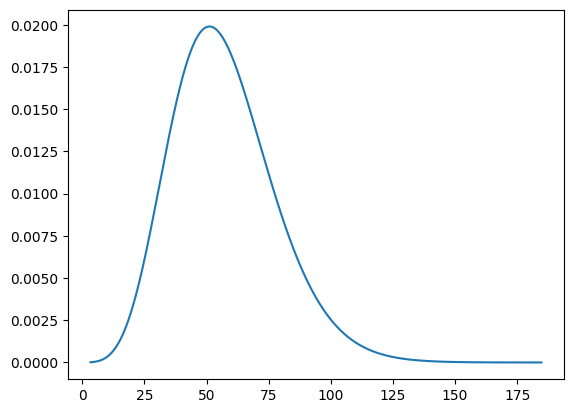

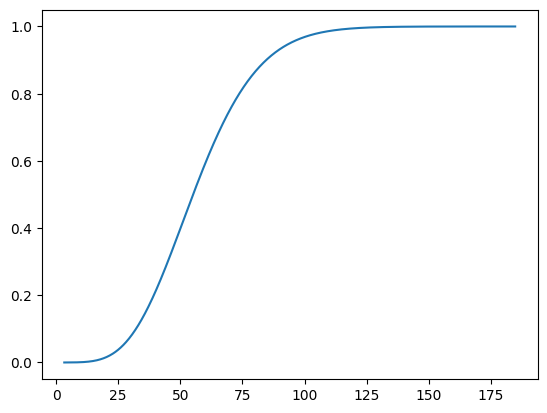

In [3]:
from scipy.signal import fftconvolve
from scipy.stats import ncx2
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import cumulative_trapezoid as cumtrapz

from scipy.interpolate import UnivariateSpline
def GeneralizedNonCenteredChi2(lambda_i, mu_i):
    df, nc_i = 1, (mu_i ** 2)

    # Define lower bound using 0.01 percentile
    lower_list = [ncx2.ppf(0.0001, df=df, nc=nc_i[i], scale=lambda_i[i]) for i in range(len(mu_i))]
    lower = min(lower_list)  # Use the minimum to cover all distributions
    if lower < 1e-4:
        lower = 0  # Ensure non-negative

    # Compute high percentiles for a robust upper bound
    upper_list = [ncx2.ppf(0.9999, df=df, nc=nc_i[i], scale=lambda_i[i]) for i in range(len(mu_i))]
    upper = max(upper_list) * 1.1  # Add margin for tails

    # Unified grid with more points for resolution
    num_points = 2 ** 12  # 4096 points for better accuracy
    common_range = np.linspace(0, upper, num_points)
    dx = common_range[1] - common_range[0]

    # Recompute PDFs on the common grid
    chi2_list = [ncx2.pdf(common_range, df=df, nc=nc_i[i], scale=lambda_i[i]) for i in range(len(mu_i))]

    convolution = chi2_list[0]
    for chi2 in chi2_list[1:]:
        convolution = fftconvolve(convolution, chi2, mode='full') * dx

    # Grid for the final convolved PDF (sum ranges from 0 to ~3*upper)
    conv_range = np.linspace(0, common_range[-1] * len(mu_i), len(convolution))

    # Check integral (should be ~1)
    integral = integrate.trapezoid(convolution, conv_range)
    # print(f"Convolved PDF integral: {integral:.4f}")  # Adjust if <0.99 or >1.01
    if np.abs(1 - integral) > 0.01:
        convolution /= integral
        # print("New norm:", integrate.trapezoid(convolution, conv_range))

    pdf_spl = UnivariateSpline(conv_range, convolution, s=0, ext=3)
    
    # Compute CDF using cumulative integration
    cdf = cumtrapz(convolution, conv_range, initial=0)
    # Ensure CDF is non-decreasing and bounded at 1
    cdf = np.clip(cdf, 0, 1)
    # Create spline for CDF
    cdf_spl = UnivariateSpline(conv_range, cdf, s=0, ext=3)
    conv_range = np.linspace(np.sum(lower_list), np.sum(upper_list), 2 ** 10)
    return conv_range, pdf_spl, cdf_spl

mu_i = np.array([5, 2])  # Extended to three means
lambda_i = np.array([2, 1])  # Extended to three scales

conv_range, pdf_spl, cdf_spl = GeneralizedNonCenteredChi2(lambda_i, mu_i)

plt.figure()
plt.plot(conv_range, pdf_spl(conv_range))

plt.figure()
plt.plot(conv_range, cdf_spl(conv_range))

## Quadrature Weights Fluctuations

- Let's define the *moment-orthogonal* polynomials as

$$\langle q_{n}^{\left(k\right)}\left(\xi\right)\xi^{p}\rangle_{\omega}=\delta_{pk},\qquad p\leq n,$$
$$q_{n}^{\left(k\right)}\left(\xi\right)=\sum_{m=0}^{n}\alpha_{m}^{\left(k\right)}\xi^{m},\qquad \alpha_{r}^{\left(k\right)}=\left[\mathrm{H}^{\left(n\right)}\right]_{rk}^{-1},$$

- Let's define the fluctuating weights

$$\hat{w}_{i}=\frac{w_{i}}{Z}\exp\left[\sum_{p=0}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}\right]$$

with the normalization that can be expanded to second order

$$\begin{split}&Z=\sum_{i=1}^{N}w_{i}\exp\left[\sum_{p=0}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}\right]\simeq\sum_{i=1}^{N}w_{i}\left(1+\sum_{p=0}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}+\frac{1}{2}\sum_{r,s=0}^{n}q_{n}^{\left(r\right)}\left(\xi_{i}\right)q_{n}^{\left(s\right)}\left(\xi_{i}\right)\delta m_{r}\delta m_{s}\right)\\&=\langle1\rangle_{w}+\sum_{p=0}^{n}\langle q_{n}^{\left(p\right)}\left(\xi_{i}\right)\rangle_{w}\delta m_{p}+\frac{1}{2}\sum_{r,s=0}^{n}\langle q_{n}^{\left(r\right)}\left(\xi_{i}\right)q_{n}^{\left(s\right)}\left(\xi_{i}\right)\rangle_{w}\delta m_{r}\delta m_{s}\\&=1+\delta m_{0}+\frac{1}{2}\sum_{r,s=0}^{n}\alpha_{r}^{\left(s\right)}\delta m_{r}\delta m_{s}=1+\frac{1}{2}\sum_{r,s=1}^{n}\left[\mathrm{H}^{\left(n\right)}\right]_{rs}^{-1}\delta m_{r}\delta m_{s},\qquad\delta m_{0}=0\end{split}$$

yielding

$$Z\simeq1+\frac{1}{2}\sum_{r,s=1}^{n}\left[\mathrm{H}^{\left(n\right)}\right]_{rs}^{-1}\delta m_{r}\delta m_{s}$$

- Let's look at the logarithm of the weights

$$\log\hat{w}_{i}=-\frac{1}{2}\sum_{r,s=1}^{n}\left[\mathrm{H}^{\left(n\right)}\right]_{rs}^{-1}\delta m_{r}\delta m_{s}+\sum_{p=1}^{n}q_{n}^{\left(p\right)}\left(\xi_{i}\right)\delta m_{p}+\log w_{i}$$

$$\begin{split}&Y=\mathbf{X}^{\top}A\mathbf{X}=\sum_{k=1}^{n}\lambda_{k}U_{k}^{2},\qquad\mathbf{X}\sim\mathcal{N}\left(\boldsymbol{\nu},C\right),\qquad U_{k}\sim\mathcal{N}\left(\eta_{k},1\right),\qquad\eta_{k}=P_{kr}^{\top}S_{rs}^{-1}\nu_{s},\qquad S=\left[C\right]^{1/2},\qquad S^{\top}AS=P\Gamma P^{\top}\\&\phi_{Y}\left(t\right)=\prod_{k=1}^{n}\phi_{\lambda_{k}Z^{2}}\left(t\right)=\prod_{k=1}^{n}\frac{1}{\sqrt{1-2\imath\lambda_{k}t}}\exp\left(\frac{\imath\lambda_{k}\eta_{k}^{2}t}{1-2\imath\lambda_{k}t}\right)\end{split}$$

## Gaussian Quadratures - $p(\hat{w})$

In [4]:
def GetPDFCDFLogW(Hm1_T, Cpq_beta, q_poly_evals, w_i):
    # Ensure Cpq_beta is positive semi-definite
    if not np.all(np.linalg.eigvals(Cpq_beta) >= -1e-10):
        Cpq_beta = (Cpq_beta + Cpq_beta.T) / 2  # Symmetrize
        Cpq_beta = Cpq_beta + np.eye(Cpq_beta.shape[0]) * 1e-10  # Add small diagonal

    A = Hm1_T[1:, 1:]
    if np.linalg.cond(A) > 1e10:
        raise ValueError("Matrix A is ill-conditioned, consider regularization")
    Am1 = np.linalg.inv(A)

    # Eigenvalue decompositions with sorting
    Lambda, Q = np.linalg.eigh(A @ Cpq_beta)
    idx_sort = np.argsort(np.abs(Lambda))[::-1]
    Lambda = Lambda[idx_sort].real  # Take real part to avoid numerical artifacts
    Q = Q[:, idx_sort]

    D, V = np.linalg.eig(Cpq_beta)
    idx_sort_D = np.argsort(D)[::-1]
    D = D[idx_sort_D].real
    V = V[:, idx_sort_D]
    S = V @ np.diag(np.sqrt(np.maximum(D, 0))) @ V.T
    Sm1 = V @ np.diag(1 / np.sqrt(np.maximum(D, 1e-10))) @ V.T

    ATilda = S.T @ A @ S
    Gamma, P = np.linalg.eigh(ATilda)
    idx_sort_G = np.argsort(Gamma)[::-1]
    Gamma = Gamma[idx_sort_G].real
    P = P[:, idx_sort_G]

    # Transform nu_i to the eigenbasis of ATilda
    ranges_list, pdf_list, cdf_list = [], [], []
    for idx in range(len(w_i)):
        b_i = q_poly_evals[1:, idx]
        mu_i = Am1 @ b_i
        nu_i = -mu_i

        eta_i = P.T @ (Sm1 @ nu_i)
        eta_i = np.where(np.abs(eta_i) < 1e-6, 1e-6, eta_i)
        d_i = 0.5 * b_i @ Am1 @ b_i + np.log(w_i[idx])

        conv_range, pdf_spl, cdf_spl = GeneralizedNonCenteredChi2(Gamma, eta_i)
        
        log_w_range = d_i-conv_range/2
        log_w_pdf_spl = UnivariateSpline(np.flip(log_w_range), np.flip(2 * pdf_spl(conv_range)), s=0, ext=3)
        log_w_cdf_spl = UnivariateSpline(np.flip(log_w_range), 1 - cdf_spl(np.flip(conv_range)), s=0, ext=3)
        log_w_range = np.flip(log_w_range)
        
        ranges_list += [log_w_range]
        pdf_list += [log_w_pdf_spl]
        cdf_list += [log_w_cdf_spl]
        
    return ranges_list, pdf_list, cdf_list

In [5]:
def GetGaussianCopulaLogW(Hm1_T, Cpq_beta, q_poly_evals, w_i):
    # Ensure Cpq_beta is positive semi-definite
    if not np.all(np.linalg.eigvals(Cpq_beta) >= -1e-10):
        Cpq_beta = (Cpq_beta + Cpq_beta.T) / 2  # Symmetrize
        Cpq_beta = Cpq_beta + np.eye(Cpq_beta.shape[0]) * 1e-10  # Add small diagonal

    A = Hm1_T[1:, 1:]
    if np.linalg.cond(A) > 1e10:
        raise ValueError("Matrix A is ill-conditioned, consider regularization")
    Am1 = np.linalg.inv(A)

    # Eigenvalue decompositions with sorting
    Lambda, Q = np.linalg.eigh(A @ Cpq_beta)
    idx_sort = np.argsort(np.abs(Lambda))[::-1]
    Lambda = Lambda[idx_sort].real  # Take real part to avoid numerical artifacts
    Q = Q[:, idx_sort]

    D, V = np.linalg.eig(Cpq_beta)
    idx_sort_D = np.argsort(D)[::-1]
    D = D[idx_sort_D].real
    V = V[:, idx_sort_D]
    S = V @ np.diag(np.sqrt(np.maximum(D, 0))) @ V.T
    Sm1 = V @ np.diag(1 / np.sqrt(np.maximum(D, 1e-10))) @ V.T

    ATilda = S.T @ A @ S
    Gamma, P = np.linalg.eigh(ATilda)
    idx_sort_G = np.argsort(Gamma)[::-1]
    Gamma = Gamma[idx_sort_G].real
    P = P[:, idx_sort_G]

    # Transform nu_i to the eigenbasis of ATilda
    eta_i_list = []
    for idx in range(len(w_i)):
        b_i = q_poly_evals[1:, idx]
        mu_i = Am1 @ b_i
        nu_i = -mu_i

        eta_i = P.T @ (Sm1 @ nu_i)
        eta_i = np.where(np.abs(eta_i) < 1e-6, 1e-6, eta_i)
        eta_i_list += [eta_i]
        
    eta_i_list = np.array(eta_i_list)

    cov_YY = [[np.sum((Lambda ** 2) * (2 + 4 * eta_i_list[i, :] * eta_i_list[j, :])) for j in range(len(w_i))] for i in range(len(w_i))]
    cov_logWlogW = np.array(cov_YY) / 4

    corr_logWlogW = np.array([[cov_logWlogW[i, j] / np.sqrt(cov_logWlogW[i, i] * cov_logWlogW[j, j]) 
                               for j in range(len(w_i))] 
                              for i in range(len(w_i))])

    return cov_logWlogW, corr_logWlogW

def Extract2BY2(M, ttuple):
    a, b = ttuple[0], ttuple[1]
    return np.array([[M[a, a], M[a, b]], [M[b, a], M[b, b]]])



In [35]:
def GaussMs(k):
    if k == 0:
        return 1.0
    if k % 2 == 1:
        return 0
    else:
        return float(sp.factorial2(k - 1))

q_degree = 7
"""
Quadrature first, hat_x_i, w_i ... what a waste
"""
gauss_degree = q_degree + 1

H = np.array([[GaussMs(i + j) for j in range(gauss_degree + 1)] for i in range(gauss_degree + 1)])
Hm1_T = np.linalg.inv(H).T

q_polys_c = np.array([Hm1_T @ np.array([1 if j == i else 0 for j in range(gauss_degree + 1)]) for i in range(gauss_degree + 1)])
q_polys_c_np = np.array([np.flip(cs) for cs in q_polys_c])
orthogonal_poly_cs = q_polys_c_np[-1]

hat_x_i = np.sort(np.roots(orthogonal_poly_cs))

VMM = np.array([[x ** p for p in range(gauss_degree)] for x in hat_x_i])
VMM_det = np.linalg.det(VMM)
VMM_i = lambda i: np.array([H[0,:gauss_degree] if i == j else [x ** p for p in range(gauss_degree)]for j, x in enumerate(hat_x_i)])
VMM_i_det = lambda i: np.linalg.det(VMM_i(i))

w_i = np.array([VMM_i_det(i) / VMM_det for i in range(gauss_degree)])

print("w_i:", w_i)
print("hat_x_i:", hat_x_i)

"""
Moment-orthogonal polynomials
"""
H = np.array([[GaussMs(i + j) for j in range(q_degree + 1)] for i in range(q_degree + 1)])
Hm1_T = np.linalg.inv(H).T

q_polys_c = np.array([Hm1_T @ np.array([1 if j == i else 0 for j in range(q_degree + 1)]) for i in range(q_degree + 1)])
q_polys_c_np = np.array([np.flip(cs) for cs in q_polys_c])

q_polys_lams = [lambda x, c=cs: np.polyval(c, x) for cs in q_polys_c_np]
q_poly_evals = np.array([f(hat_x_i) for f in q_polys_lams])
q_poly_evals_T = q_poly_evals.T

"""
Preparing the correlations for the Moment Lattice Model
"""
def GetCpq(P, ms_lam):
    ms_dict_P = {p: ms_lam(p) for p in range(1, 2 * P + 1, 1)}
    num_lam = lambda p, q: ms_dict_P[p + q] - ms_dict_P[p] * ms_dict_P[q]
    den_lam = lambda p, q: np.sqrt((ms_dict_P[2 * p] - (ms_dict_P[p] ** 2)) * (ms_dict_P[2 * q] - (ms_dict_P[q] ** 2)))
    Cpq = np.array([[num_lam(p, q) / den_lam(p, q) for q in range(1, P + 1)] for p in range(1, P + 1)])
    return Cpq

Cpq = GetCpq(q_degree, GaussMs)

def FindMaxBeta(P, ms_lam, GL_ratio=0.1):
    ratios_mm2 = np.array([ms_lam(p) / np.sqrt((ms_lam(2 * p) - (ms_lam(p) ** 2))) for p in range(1, P + 1)])
    ratios_mm2 = ratios_mm2[ratios_mm2 > 0]
    kBT_min = 1 / np.sort(ratios_mm2)[0]
    beta_max = (1 / kBT_min) * GL_ratio

    return beta_max

beta_max = FindMaxBeta(q_degree, GaussMs)

print("beta_max:", beta_max)

def SqrtVar(p, ms_lam, beta=1):
    return np.sqrt(beta * (ms_lam(2 * p) - (ms_lam(p) ** 2)))

def GetDeltaMs(Cpq, ms_lam, beta, size=1):
    P_ms = Cpq.shape[0]
    phi_p = np.array(np.random.multivariate_normal([0] * P_ms, Cpq, size=size).squeeze())
    return np.array([0] + list(phi_p * np.array([SqrtVar(p, ms_lam, beta) for p in range(1, P_ms + 1)])))

def HatWRnd(Cpq, ms_lam, beta, size=1):
    hat_w_i = w_i * np.exp(q_poly_evals_T @ GetDeltaMs(Cpq, ms_lam, beta, size=size))
    return hat_w_i / np.sum(hat_w_i)

beta, n_hat_samples = beta_max * 0.06, 2 ** 17
hat_w_sample = np.array([HatWRnd(Cpq, GaussMs, beta) for k in range(n_hat_samples)])

w_i: [1.12614538e-04 9.63522012e-03 1.17239908e-01 3.73012258e-01
 3.73012258e-01 1.17239908e-01 9.63522012e-03 1.12614538e-04]
hat_x_i: [-4.14454719 -2.80248586 -1.63651904 -0.53907981  0.53907981  1.63651904
  2.80248586  4.14454719]
beta_max: 0.01487410293271824


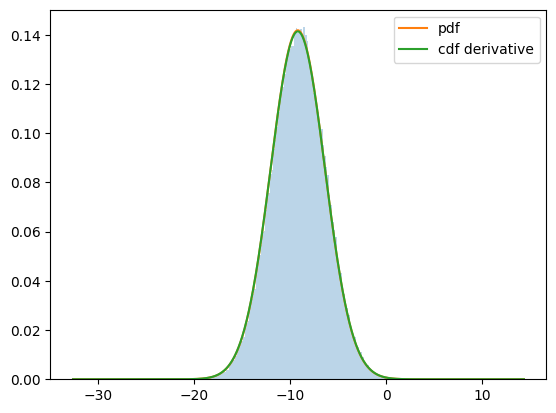

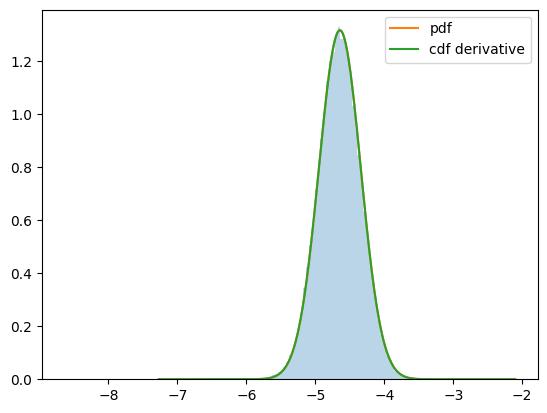

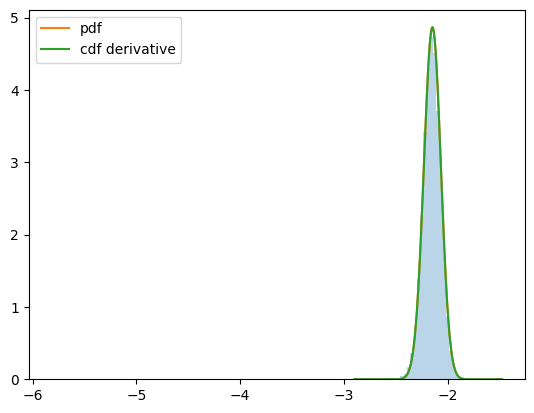

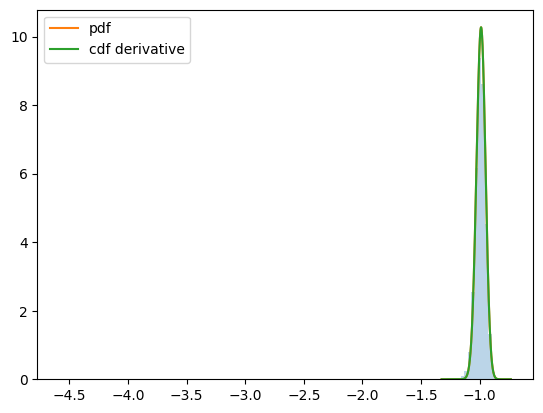

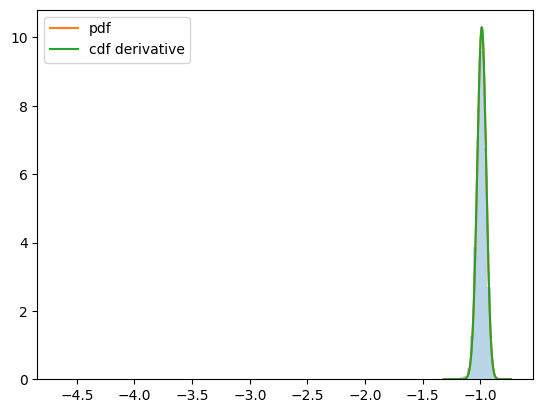

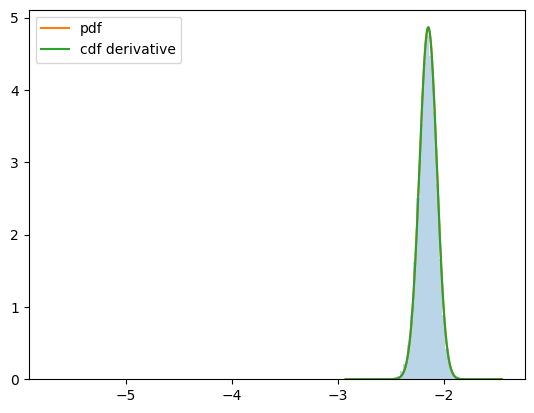

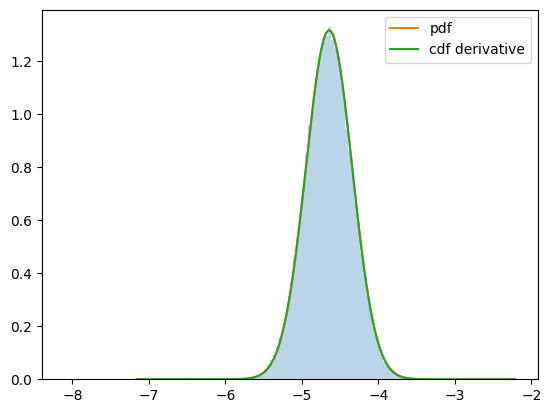

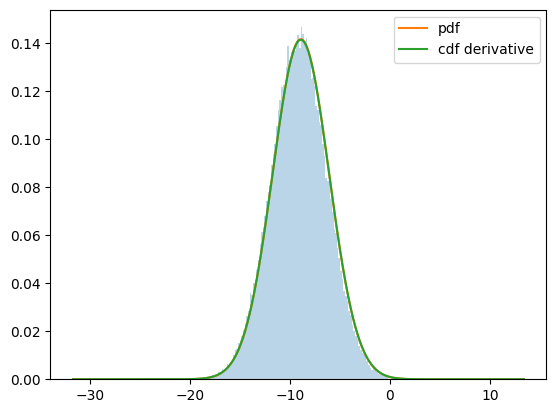

In [36]:
sqrt_beta_scale = np.diag(np.array([SqrtVar(p, GaussMs, beta) for p in range(1, q_degree + 1)]))
Cpq_beta = sqrt_beta_scale @ (Cpq @ sqrt_beta_scale)

def GetPDFCDFLogW(Hm1_T, Cpq_beta, q_poly_evals, w_i):
    # Ensure Cpq_beta is positive semi-definite
    if not np.all(np.linalg.eigvals(Cpq_beta) >= -1e-10):
        Cpq_beta = (Cpq_beta + Cpq_beta.T) / 2  # Symmetrize
        Cpq_beta = Cpq_beta + np.eye(Cpq_beta.shape[0]) * 1e-10  # Add small diagonal

    A = Hm1_T[1:, 1:]
    if np.linalg.cond(A) > 1e10:
        raise ValueError("Matrix A is ill-conditioned, consider regularization")
    Am1 = np.linalg.inv(A)

    # Eigenvalue decompositions with sorting
    Lambda, Q = np.linalg.eigh(A @ Cpq_beta)
    idx_sort = np.argsort(np.abs(Lambda))[::-1]
    Lambda = Lambda[idx_sort].real  # Take real part to avoid numerical artifacts
    Q = Q[:, idx_sort]

    D, V = np.linalg.eig(Cpq_beta)
    idx_sort_D = np.argsort(D)[::-1]
    D = D[idx_sort_D].real
    V = V[:, idx_sort_D]
    S = V @ np.diag(np.sqrt(np.maximum(D, 0))) @ V.T
    Sm1 = V @ np.diag(1 / np.sqrt(np.maximum(D, 1e-10))) @ V.T

    ATilda = S.T @ A @ S
    Gamma, P = np.linalg.eigh(ATilda)
    idx_sort_G = np.argsort(Gamma)[::-1]
    Gamma = Gamma[idx_sort_G].real
    P = P[:, idx_sort_G]

    # Transform nu_i to the eigenbasis of ATilda
    ranges_list, pdf_list, cdf_list = [], [], []
    for idx in range(len(w_i)):
        b_i = q_poly_evals[1:, idx]
        mu_i = Am1 @ b_i
        nu_i = -mu_i

        eta_i = P.T @ (Sm1 @ nu_i)
        eta_i = np.where(np.abs(eta_i) < 1e-6, 1e-6, eta_i)
        d_i = 0.5 * b_i @ Am1 @ b_i + np.log(w_i[idx])

        conv_range, pdf_spl, cdf_spl = GeneralizedNonCenteredChi2(Gamma, eta_i)
        
        log_w_range = d_i-conv_range/2
        log_w_pdf_spl = UnivariateSpline(np.flip(log_w_range), np.flip(2 * pdf_spl(conv_range)), s=0, ext=3)
        log_w_cdf_spl = UnivariateSpline(np.flip(log_w_range), 1 - cdf_spl(np.flip(conv_range)), s=0, ext=3)
        log_w_range = np.flip(log_w_range)
        
        ranges_list += [log_w_range]
        pdf_list += [log_w_pdf_spl]
        cdf_list += [log_w_cdf_spl]
        
    return ranges_list, pdf_list, cdf_list
   
ranges_list, pdf_list, cdf_list = GetPDFCDFLogW(Hm1_T, Cpq_beta, q_poly_evals, w_i)

for idx in range(len(w_i)):
    plt.figure()
    _ = plt.hist(np.log(hat_w_sample[:, idx]), density=True, bins=2**7, alpha=0.3)
    plt.plot(ranges_list[idx], pdf_list[idx](ranges_list[idx]), label='pdf')
    plt.plot(ranges_list[idx], cdf_list[idx].derivative()(ranges_list[idx]), label='cdf derivative')
    plt.legend()
    plt.show()
    plt.close()

In [8]:
# cov_sample = []
# for i in range(len(w_i)):
#     for j in range(len(w_i)):
#         cov = \
#             np.mean(np.log(hat_w_sample[:, i]) * np.log(hat_w_sample[:, j])) - \
#             np.mean(np.log(hat_w_sample[:, i])) * np.mean(np.log(hat_w_sample[:, j]))
#         cov_sample += [cov]

# cov_sample = np.array(cov_sample).reshape((len(w_i), len(w_i)))
# 1 - cov_sample / cov_logWlogW

ttuple: (0, 1)
(0, 1)


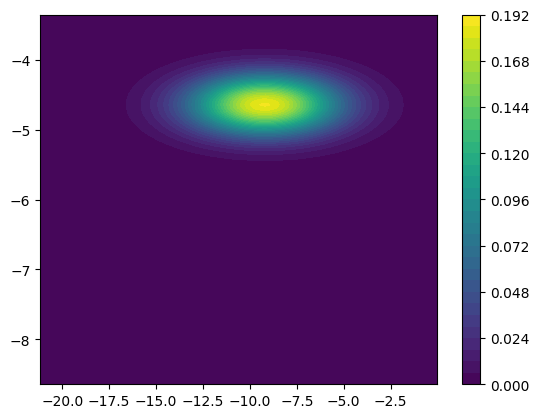

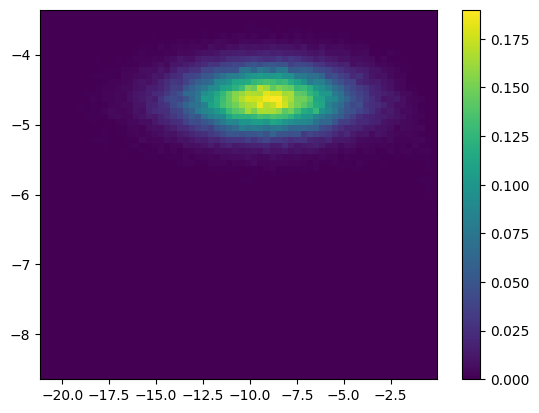


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (0, 2)
(0, 2)


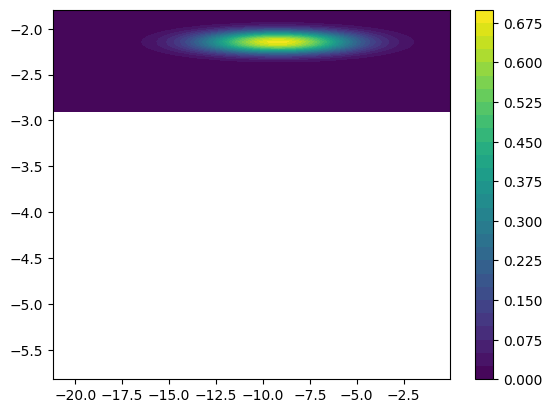

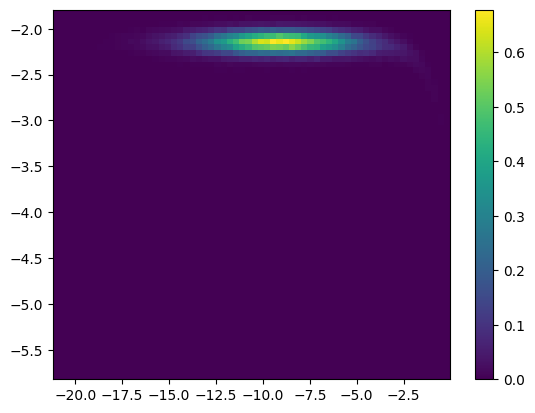


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (0, 3)
(0, 3)


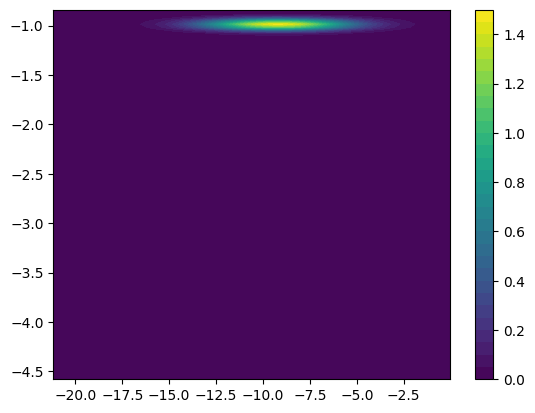

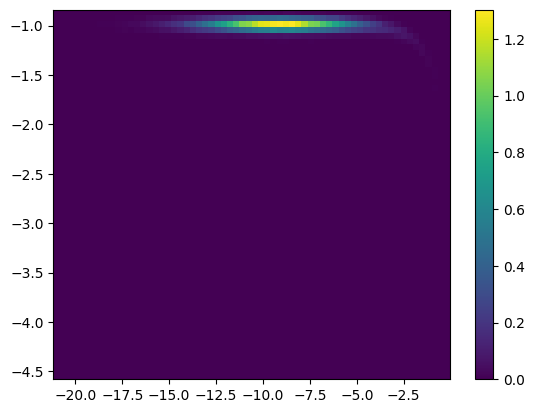


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (0, 4)
(0, 4)


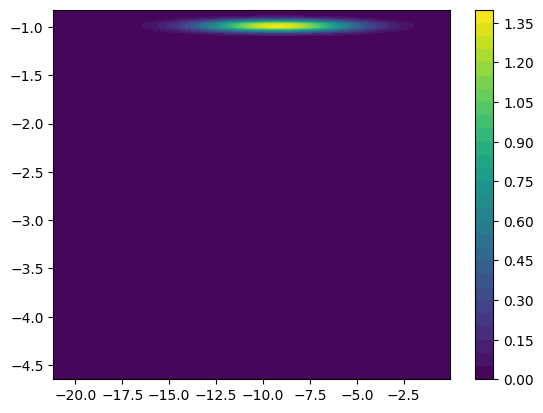

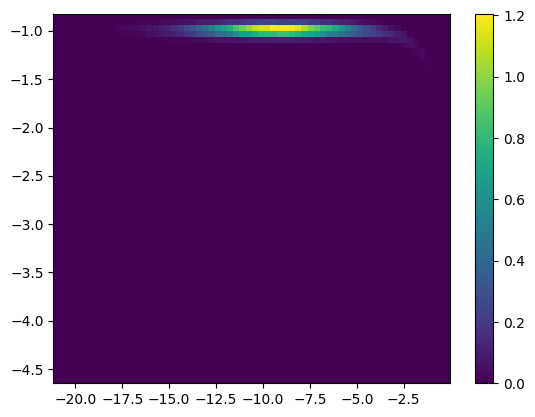


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (0, 5)
(0, 5)


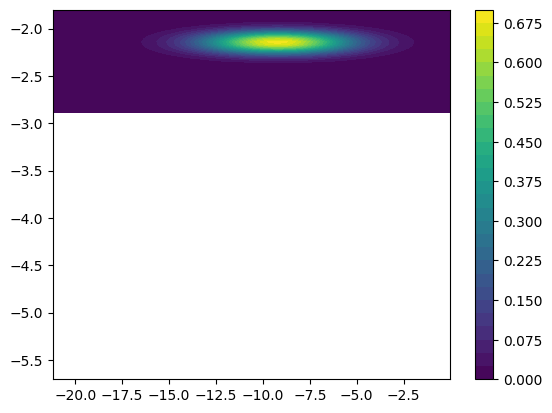

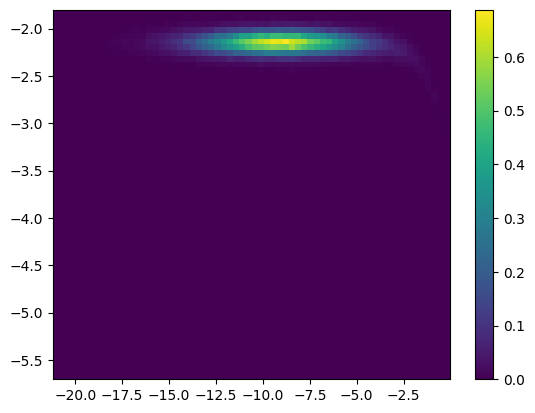


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (0, 6)
(0, 6)


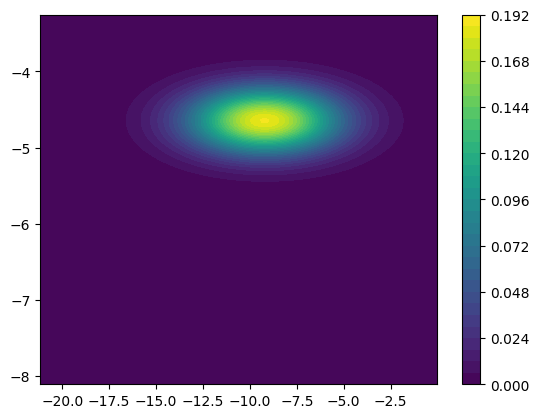

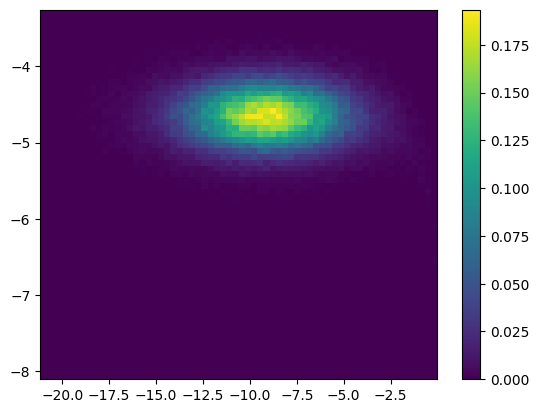


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (0, 7)
(0, 7)


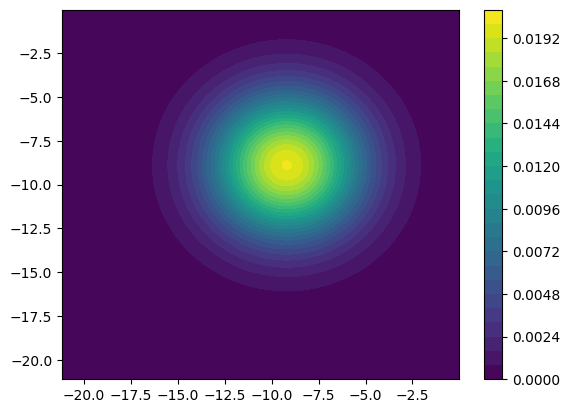

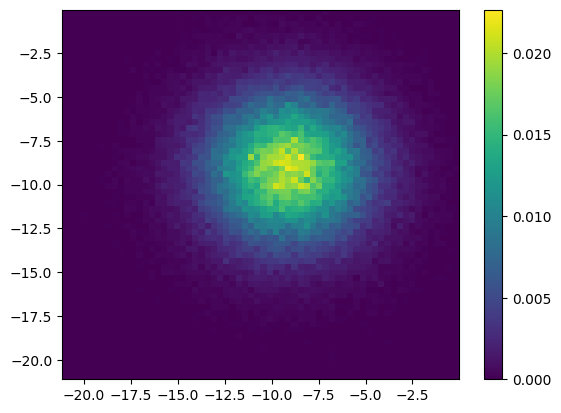


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (1, 2)
(1, 2)


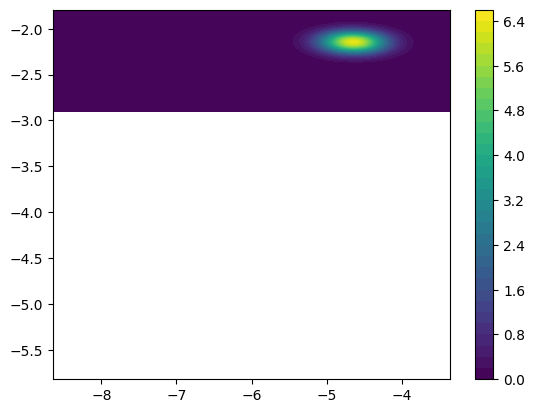

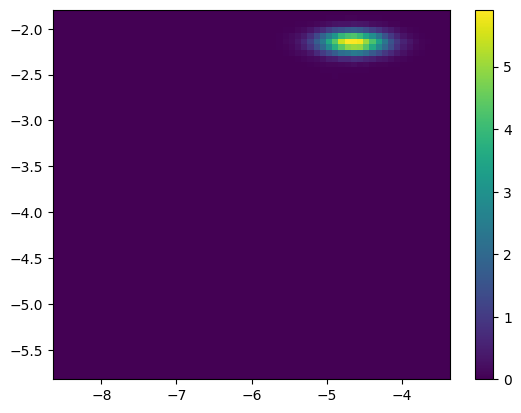


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (1, 3)
(1, 3)


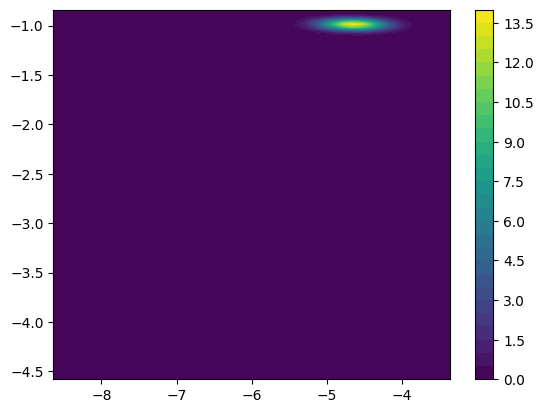

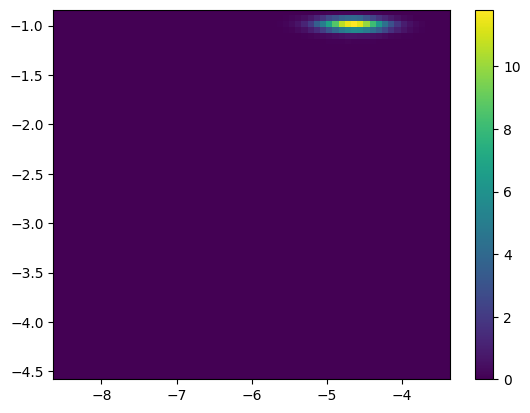


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (1, 4)
(1, 4)


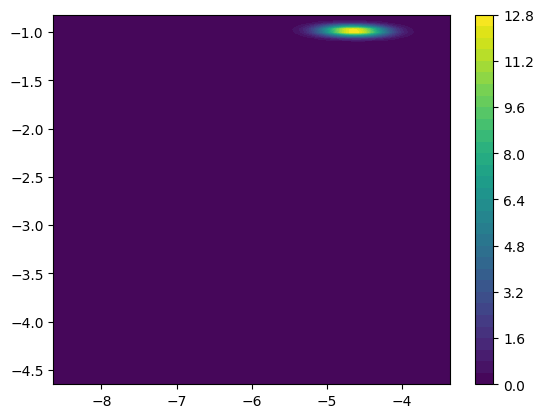

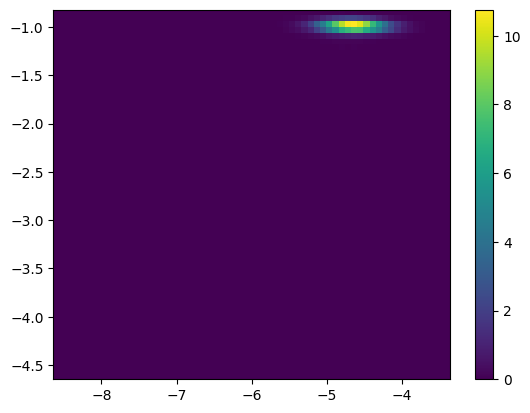


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (1, 5)
(1, 5)


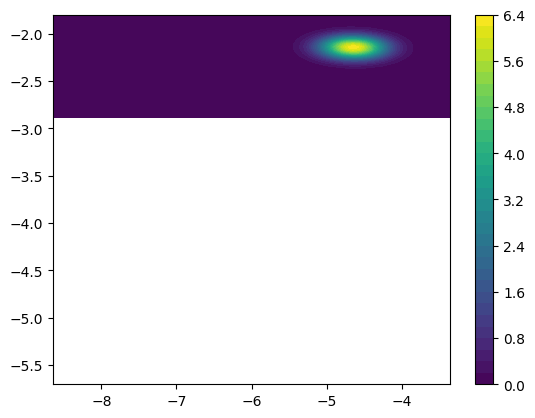

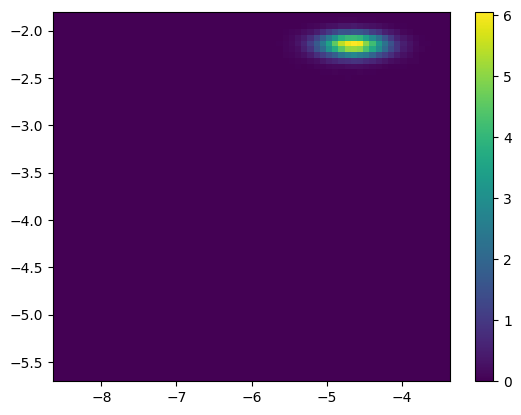


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (1, 6)
(1, 6)


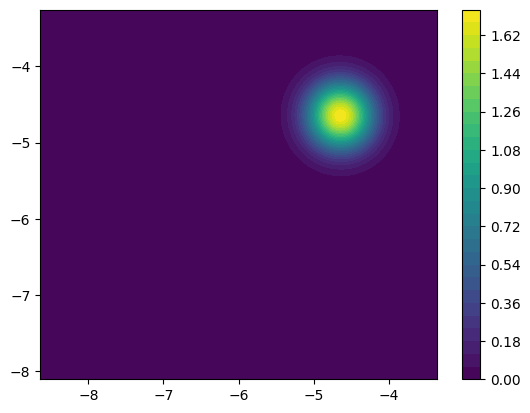

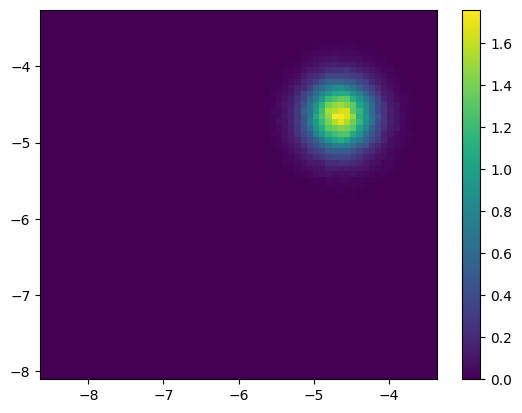


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (1, 7)
(1, 7)


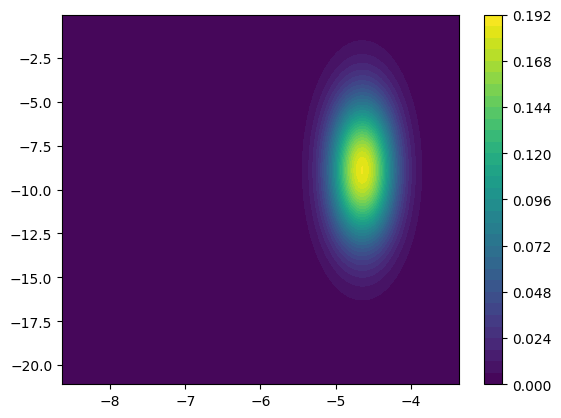

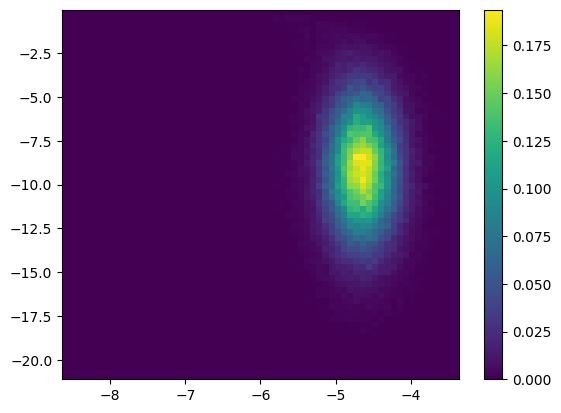


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (2, 3)
(2, 3)


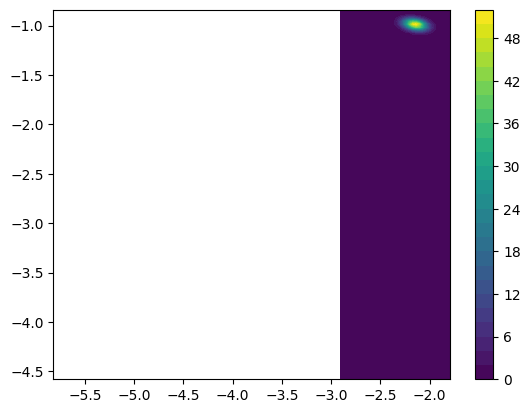

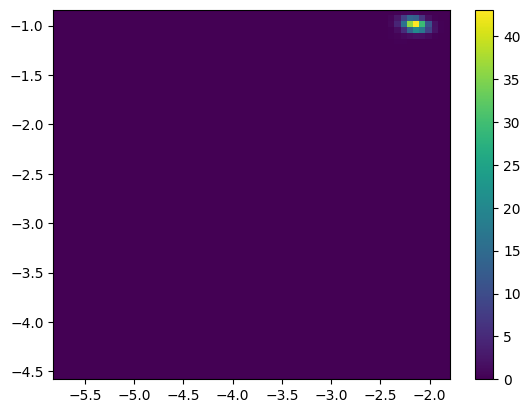


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (2, 4)
(2, 4)


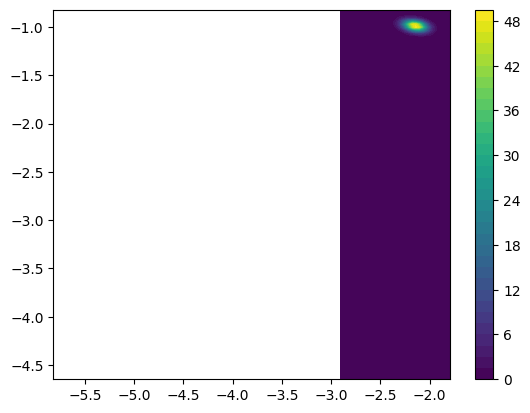

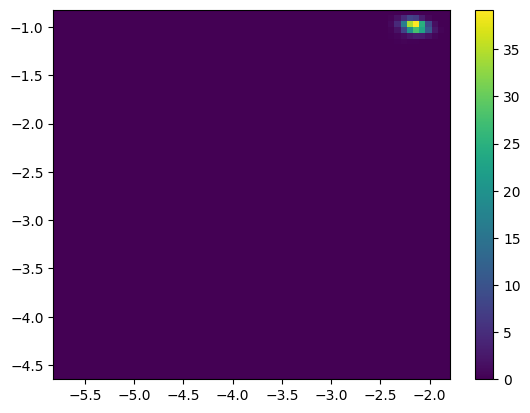


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (2, 5)
(2, 5)


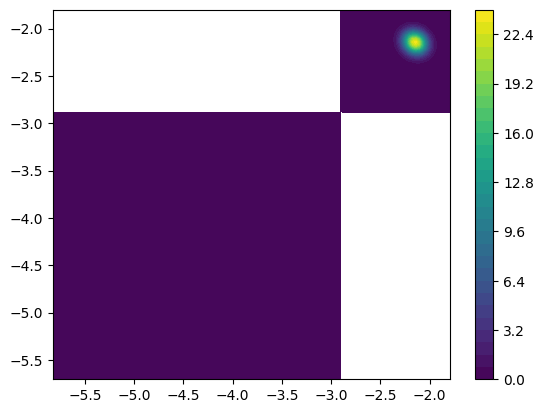

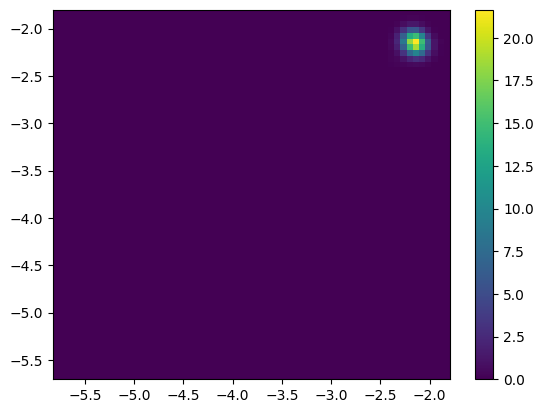


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (2, 6)
(2, 6)


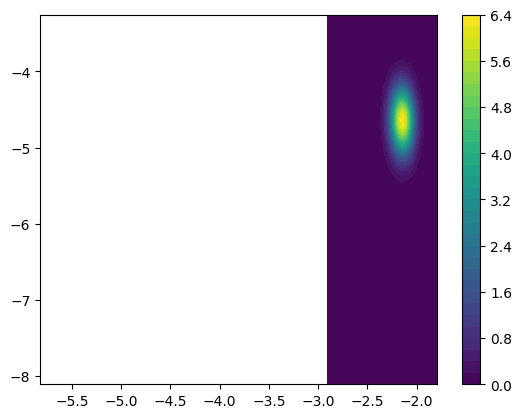

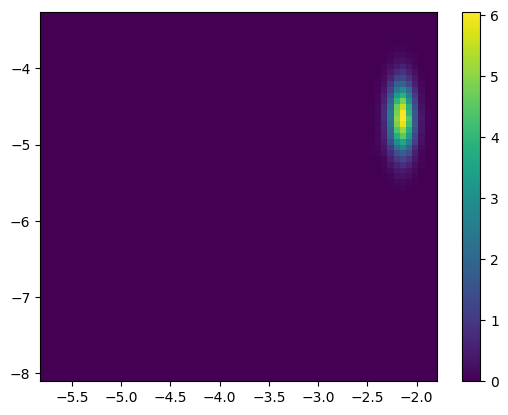


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (2, 7)
(2, 7)


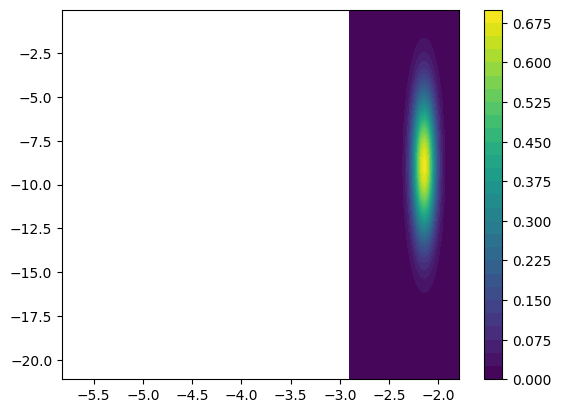

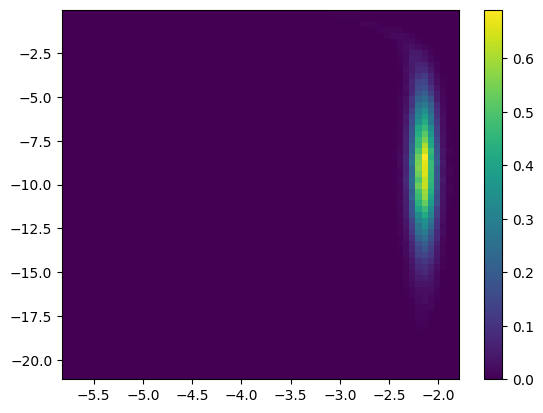


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (3, 4)
(3, 4)


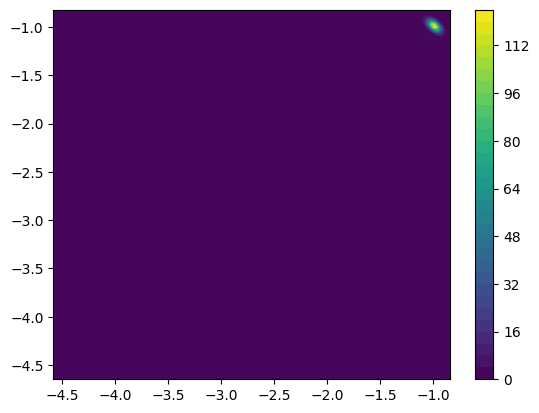

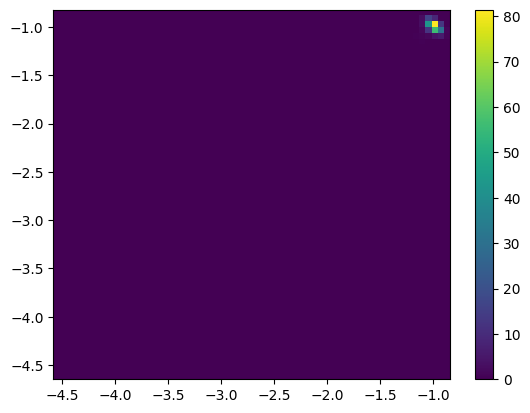


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (3, 5)
(3, 5)


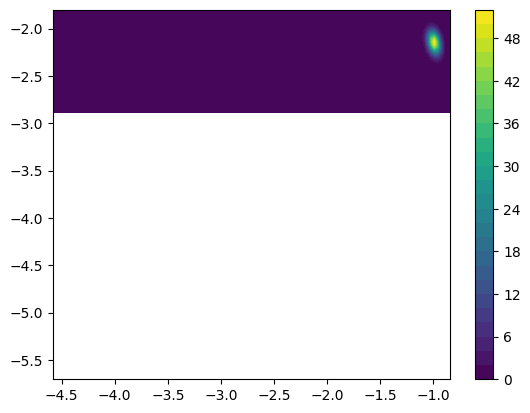

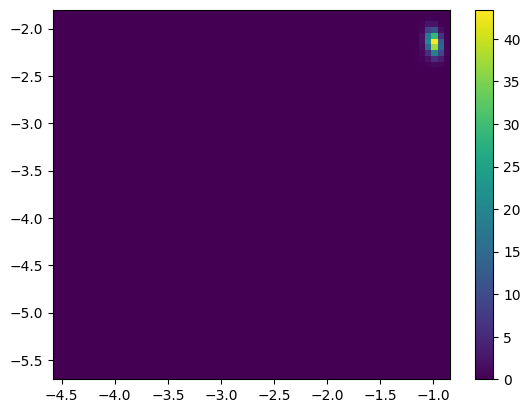


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (3, 6)
(3, 6)


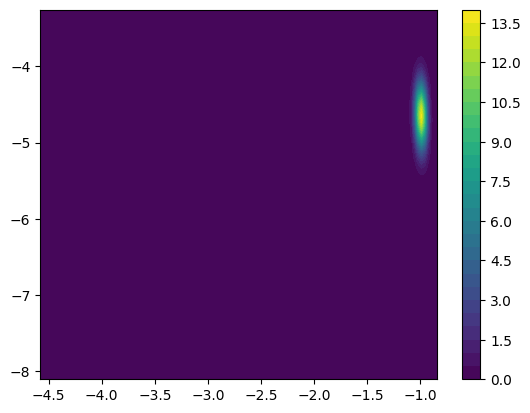

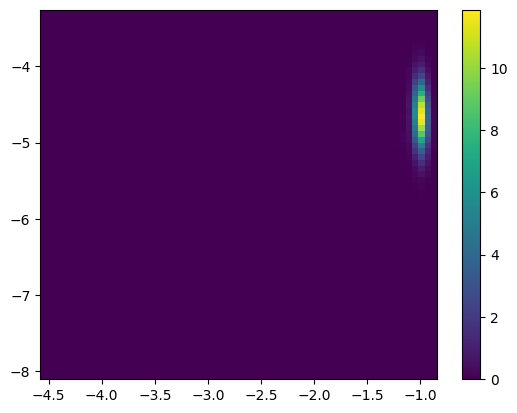


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (3, 7)
(3, 7)


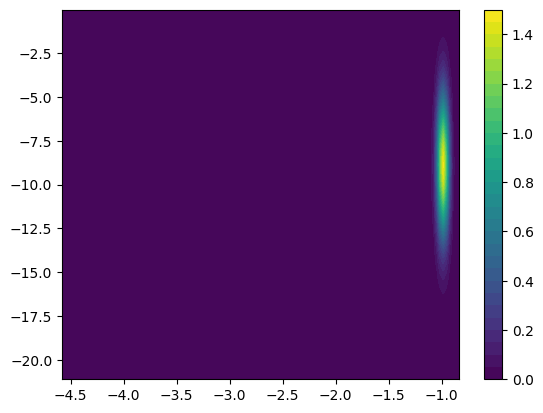

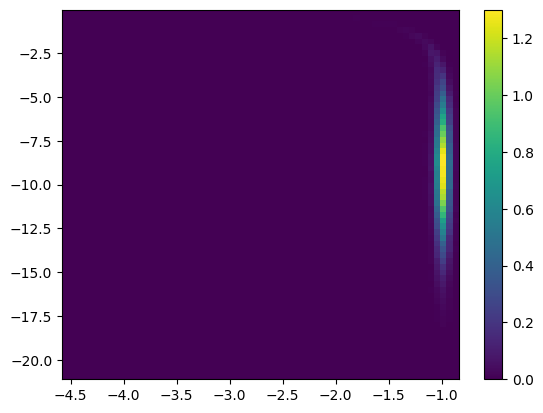


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (4, 5)
(4, 5)


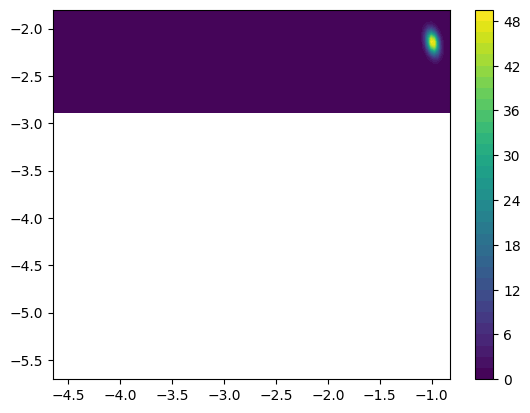

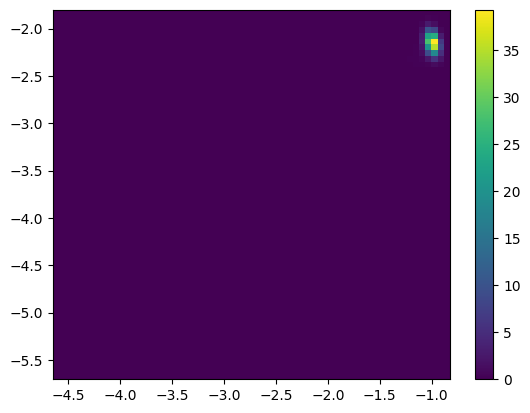


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (4, 6)
(4, 6)


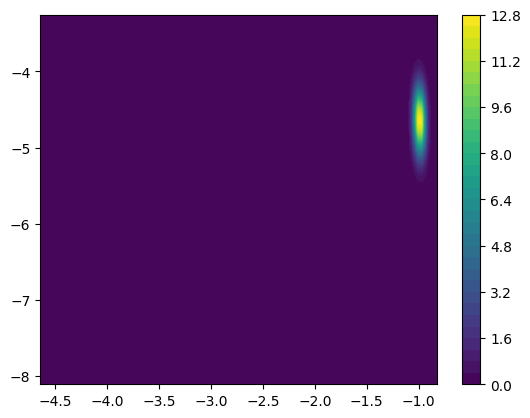

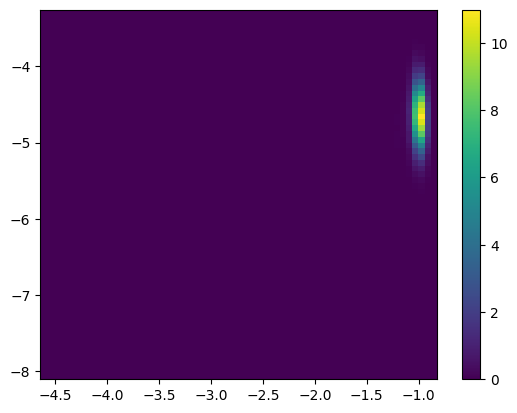


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (4, 7)
(4, 7)


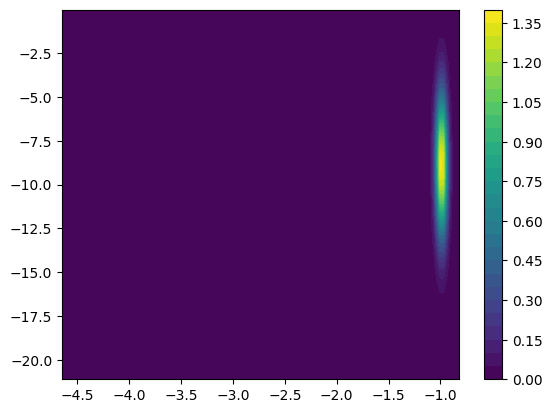

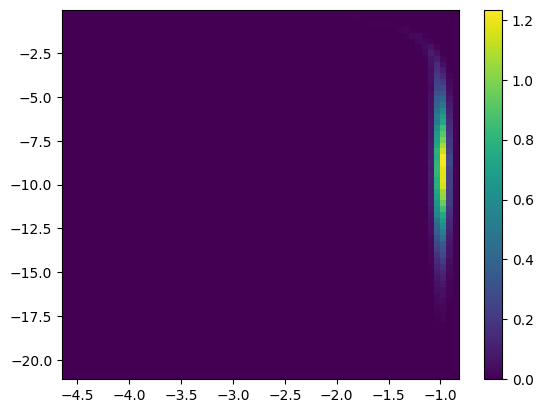


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (5, 6)
(5, 6)


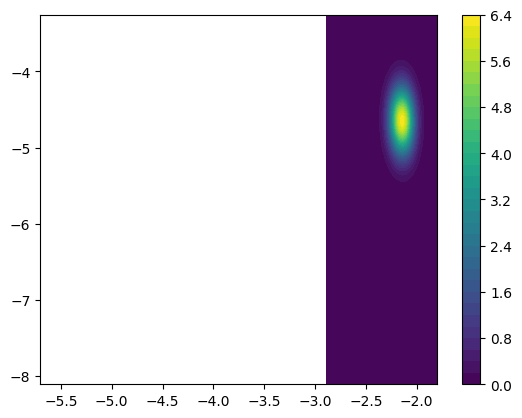

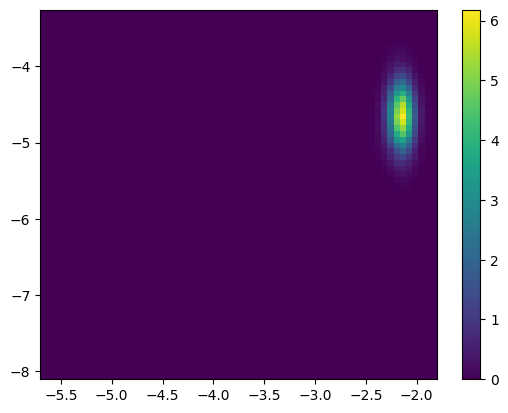


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (5, 7)
(5, 7)


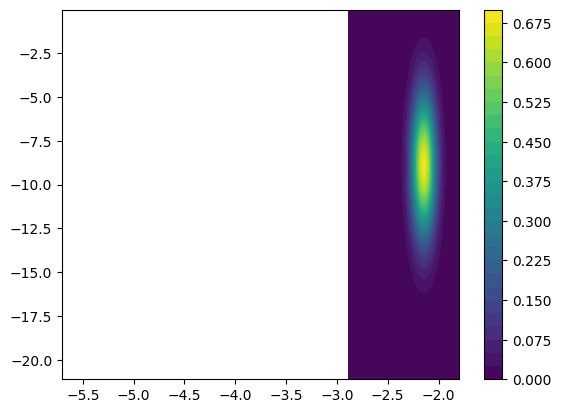

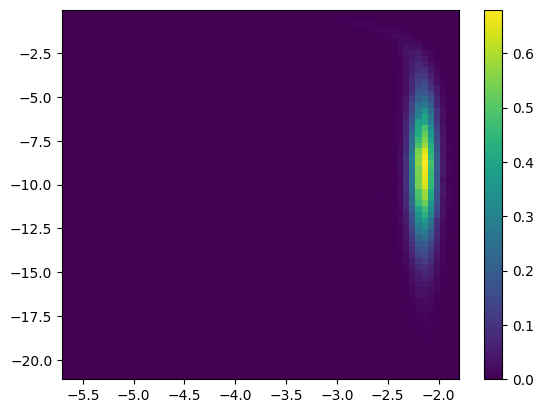


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

ttuple: (6, 7)
(6, 7)


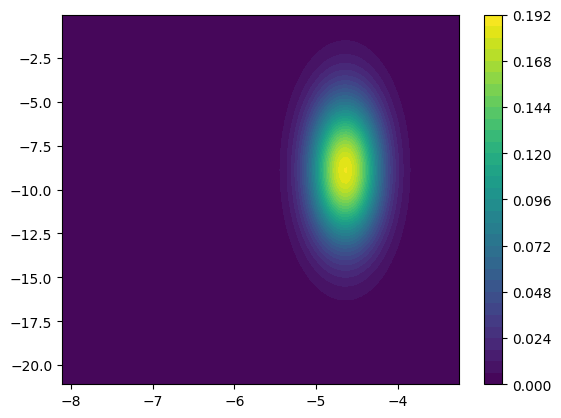

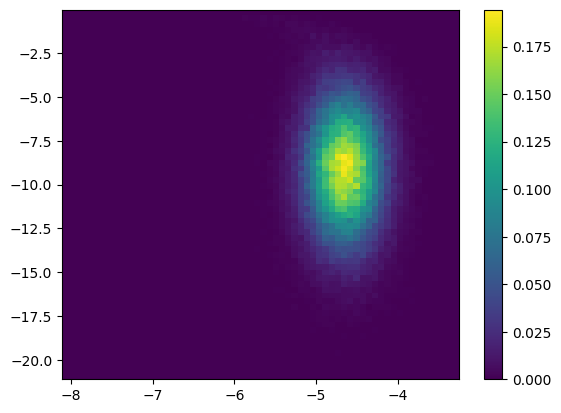


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>



In [37]:
import numpy as np
from scipy.stats import norm

# Define the Gaussian copula density (corrected for clarity)
gauss_copula = lambda z, P: np.exp(-0.5 * z.T @ (np.linalg.inv(P) - np.eye(P.shape[0])) @ z) / np.sqrt(np.linalg.det(P))

# Define Phi^{-1}
Phi_m1 = lambda u: norm.ppf(u)

# Assuming these are provided:
cov_logWlogW, corr_logWlogW = GetGaussianCopulaLogW(Hm1_T, Cpq_beta, q_poly_evals, w_i)

# ttuple = (1, 2)

for a in range(len(w_i) - 1):
    for b in range(a + 1, len(w_i)):
        ttuple = (a, b)
        print("ttuple:", ttuple)

        P = Extract2BY2(corr_logWlogW, ttuple)
        # r0, r1 = ranges_list[ttuple[0]], ranges_list[ttuple[1]]

        r0 = np.linspace(np.amin(np.log(hat_w_sample[:, ttuple[0]])), 
                        np.amax(np.log(hat_w_sample[:, ttuple[0]])), 2 ** 7)
        r1 = np.linspace(np.amin(np.log(hat_w_sample[:, ttuple[1]])), 
                        np.amax(np.log(hat_w_sample[:, ttuple[1]])), 2 ** 7)

        pdf0, pdf1 = pdf_list[ttuple[0]], pdf_list[ttuple[1]]
        cdf0, cdf1 = cdf_list[ttuple[0]], cdf_list[ttuple[1]]

        # Create meshgrid
        R0, R1 = np.meshgrid(r0, r1)  # Shapes: (len(r1), len(r0))

        # Compute u_i = F_i(log w_i) over the grid
        u0 = cdf0(R0)  # Shape: (len(r1), len(r0))
        u1 = cdf1(R1)  # Shape: (len(r1), len(r0))

        # Clip to avoid numerical issues with Phi^{-1}
        epsilon = 1e-10
        u0 = np.clip(u0, epsilon, 1 - epsilon)
        u1 = np.clip(u1, epsilon, 1 - epsilon)

        # Compute z_i = Phi^{-1}(u_i)
        z0 = Phi_m1(u0)  # Shape: (len(r1), len(r0))
        z1 = Phi_m1(u1)  # Shape: (len(r1), len(r0))

        # Initialize output array for joint PDF
        joint_pdf = np.zeros_like(R0)

        # Evaluate copula density over the grid
        for i in range(R0.shape[0]):
            for j in range(R0.shape[1]):
                # Form z vector for this grid point
                z = np.array([z0[i,j], z1[i,j]])  # Shape: (2,)
                
                # Compute copula density
                copula_density = gauss_copula(z, P)
                
                # Compute marginal PDFs
                marginal_density = pdf0(R0[i,j]) * pdf1(R1[i,j])
                
                # Joint PDF = copula density * product of marginal PDFs
                joint_pdf[i,j] = copula_density * marginal_density

        # Now joint_pdf has shape (len(r1), len(r0)) and contains p(log w_0, log w_1)

        print(ttuple)

        plt.figure()
        plt.contourf(R0, R1, joint_pdf, levels=2**5, cmap='viridis')
        plt.colorbar()
        plt.show()
        plt.close()

        plt.figure()
        _ = plt.hist2d(np.log(hat_w_sample[:, ttuple[0]]), 
                       np.log(hat_w_sample[:, ttuple[1]]), density=True, bins=2**6)
        plt.colorbar()
        plt.show()
        plt.close()
        
        print()
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
        print()
    
